<center><h1>Kan_Herun_HW6</h1></center>

Name: Herun Kan
<br>
Github Username: herunkan
<br>
USC ID: 7222919427

## 1. Tree-Based Methods

Import packages

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import  GridSearchCV, cross_val_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

### (a) Download the APS Failure data

In [7]:
training = pd.read_csv('../data/aps_failure_training_set.csv', skiprows= 20, na_values= 'na')
testing = pd.read_csv('../data/aps_failure_test_set.csv', skiprows= 20, na_values= 'na')

In [8]:
training['class'] = training['class'].replace({'neg': 0, 'pos': 1})

testing['class'] = testing['class'].replace({'neg': 0, 'pos': 1})

/var/folders/5_/zn1tlqnd50z90_mf2r06kkf40000gn/T/ipykernel_27235/3281832536.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training['class'] = training['class'].replace({'neg': 0, 'pos': 1})
/var/folders/5_/zn1tlqnd50z90_mf2r06kkf40000gn/T/ipykernel_27235/3281832536.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  testing['class'] = testing['class'].replace({'neg': 0, 'pos': 1})


### (b) Data Preparation

#### (i) Research what types of techniques are usually used

"Below are popular data imputation techniques, we are going to discuss about each of this technique in the coming sections.

Mean Imputation

Mode Imputation

Next or Previous Value 

Maximum or Minimum Value

Hot Deck Imputation

Cold Deck Imputation

Regression Imputation

K-nearest Neighbor (KNN) Imputation

Multiple Imputation"

"https://dataaspirant.com/data-imputation-techniques/"


since there are lot of missing values in the dataset, i will use mode imputation 

In [9]:
imputer = SimpleImputer(strategy = 'most_frequent')

training_imputed = pd.DataFrame(imputer.fit_transform(training), columns= training.columns)
testing_imputed = pd.DataFrame(imputer.fit_transform(testing), columns= testing.columns)

#### (ii) Calculate the coefficient of variation

In [10]:
X_train = training_imputed.iloc[:, 1:]
y_train = training_imputed.iloc[:, 0]

X_test = testing_imputed.iloc[:, 1:]
y_test = testing_imputed.iloc[:, 0]

In [11]:
CVs = {}
for column in X_train.columns:
    CVs[column] = X_train[column].std()/ X_train[column].mean()

#### (iii) Plot a correlation matrix

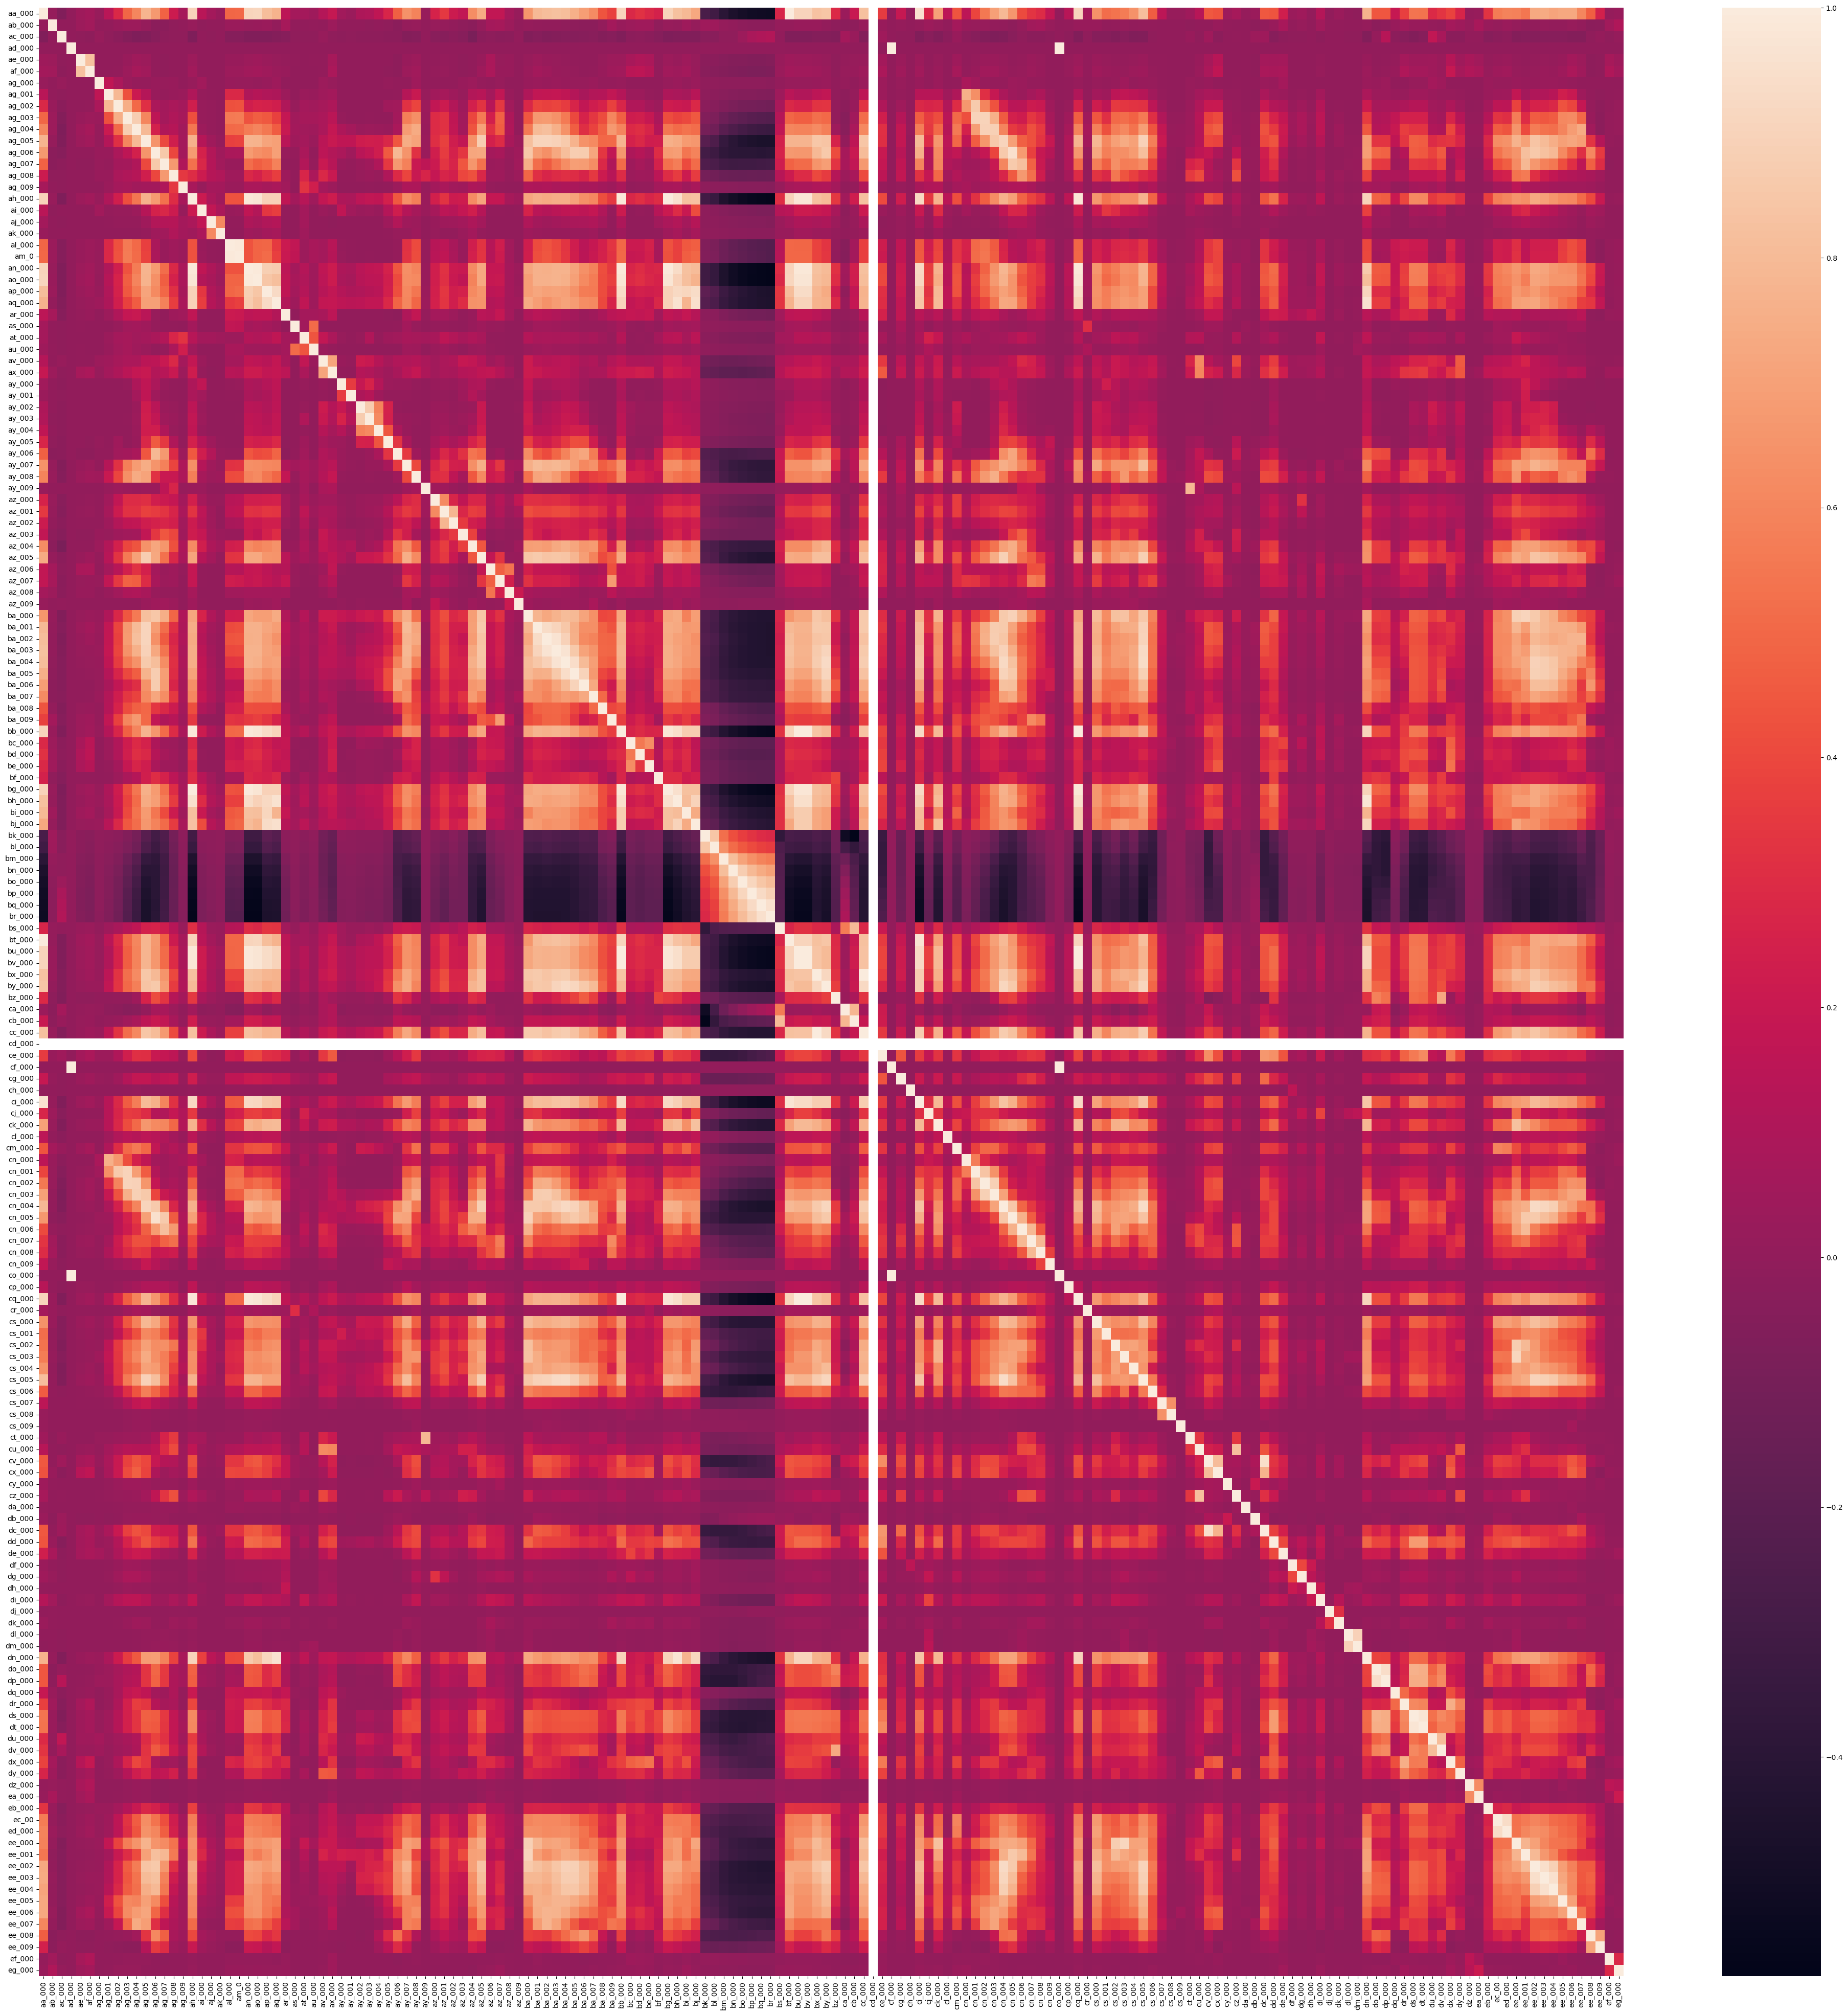

In [12]:
plt.figure(figsize=(50, 50))
corr = X_train.corr()
sns.heatmap(corr)
plt.show()

#### (iv) Make scatter plots and box plots

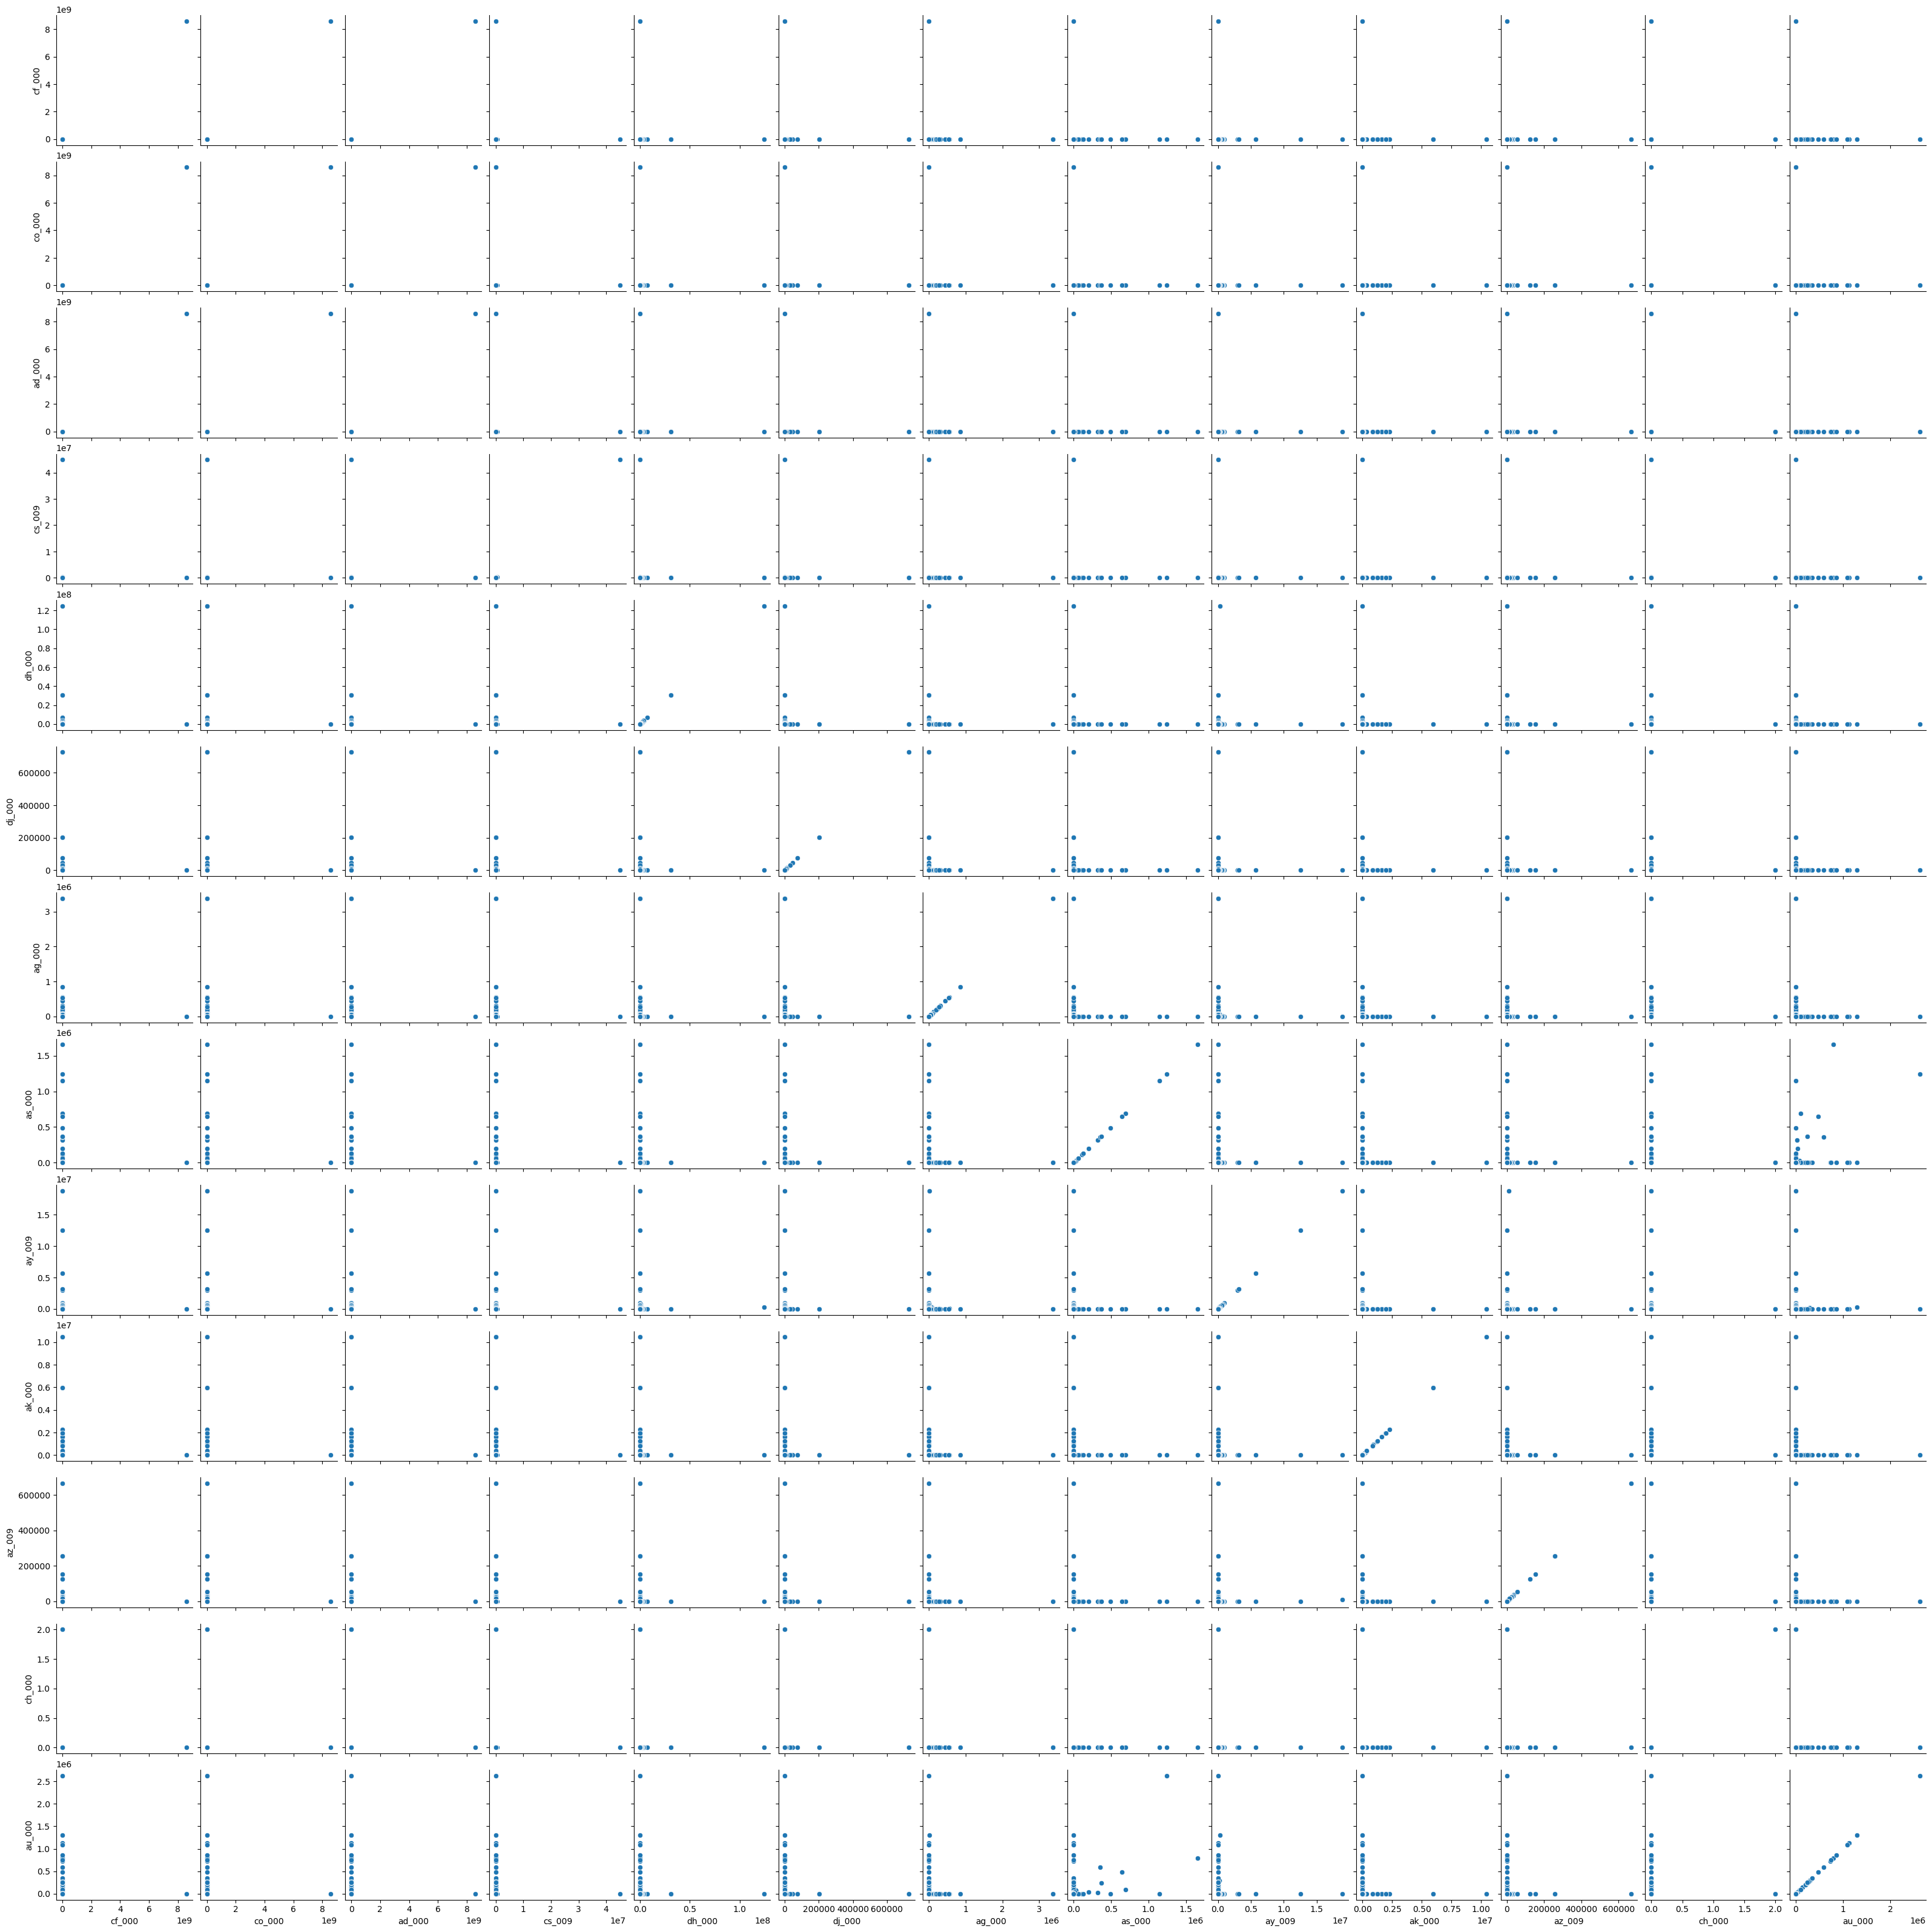

In [13]:
num = int(math.sqrt(170))
cv_series = pd.Series(CVs)

top_features = cv_series.nlargest(num).index.tolist()
X_train_top = X_train[top_features] 


sns.pairplot(X_train_top, diag_kind=None)
plt.show()

[]

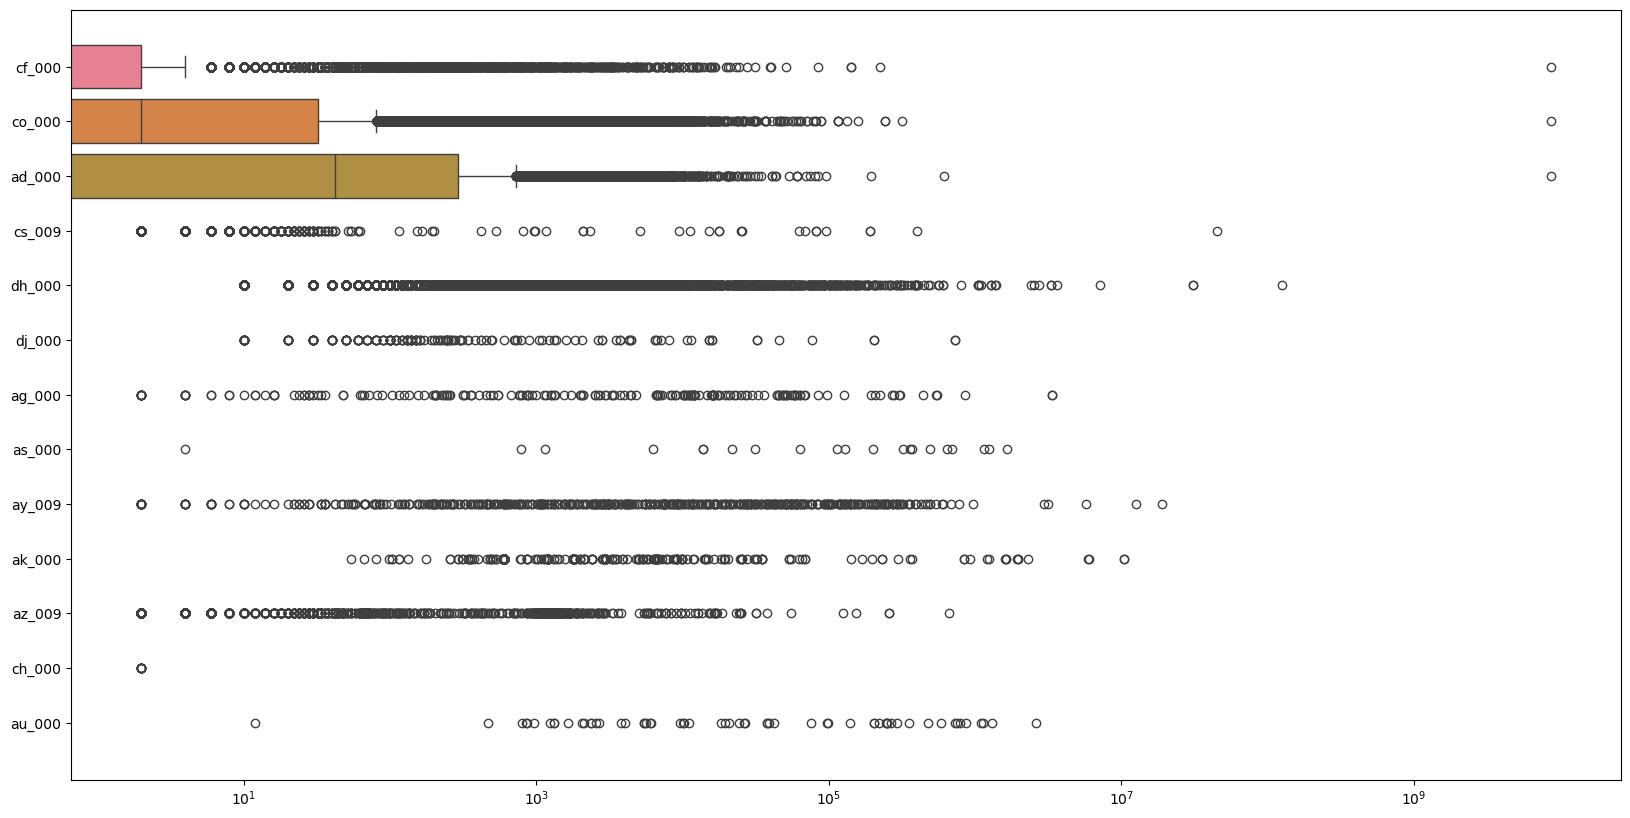

In [14]:
fig, axes = plt.subplots(figsize=(20, 10))
box = sns.boxplot(data=X_train_top, ax=axes, orient='h')
box.set(xscale='log')
plt.plot()

While the plots do show a few important features, the plots alone can not determine feature significance.

#### (v) Is this data set imbalanced?

In [15]:
display(y_train[(y_train == 0)])

display(y_train[(y_train != 0)])

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
59995    0.0
59996    0.0
59997    0.0
59998    0.0
59999    0.0
Name: class, Length: 59000, dtype: float64

9        1.0
23       1.0
60       1.0
115      1.0
135      1.0
        ... 
59484    1.0
59601    1.0
59692    1.0
59742    1.0
59769    1.0
Name: class, Length: 1000, dtype: float64

It is imbalanced considering there are only 1000 positives and 59000 negatives

### (c) Train a random forest

In [16]:
rf = RandomForestClassifier(max_depth=5, random_state=42, oob_score=True)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, oob_score=True, random_state=42)

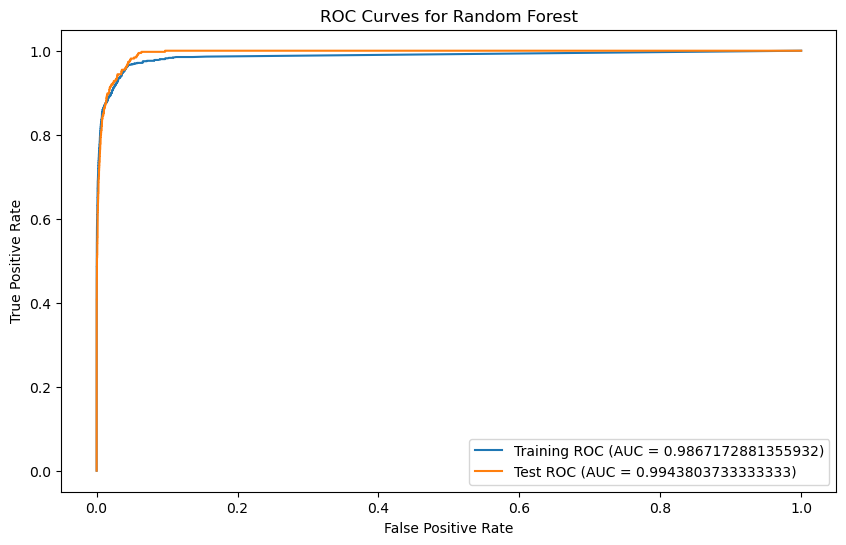

In [17]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

conf_train = confusion_matrix(y_train, train_pred)
conf_test = confusion_matrix(y_test, test_pred)

prob_train = rf.predict_proba(X_train)[:, 1] 
prob_test = rf.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds = roc_curve(y_train, prob_train)
fpr_test, tpr_test, thresholds = roc_curve(y_test, prob_test)

auc_train = roc_auc_score(y_train, prob_train)
auc_test = roc_auc_score(y_test, prob_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {auc_train})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Random Forest")
plt.legend(loc="best")
plt.show()


In [18]:
print(f'Training Confusion Matrix: {conf_train}')
print(f'Testing Confusion Matrix: {conf_test}')

print(f'Training AUC: {auc_train}')
print(f'Test AUC: {auc_test}')

misclass_train = 1 - accuracy_score(y_train, train_pred)
misclass_test = 1 - accuracy_score(y_test, test_pred)
print(f'Training Misclassification: {misclass_train}')
print(f'Test Misclassification: {misclass_test}')

oob_error = 1 - rf.oob_score_
print(f'Out-of-Bag Error Estimate: {oob_error}')
print(f'Test Error: {misclass_test}')


Training Confusion Matrix: [[58971    29]
 [  428   572]]
Testing Confusion Matrix: [[15611    14]
 [  180   195]]
Training AUC: 0.9867172881355932
Test AUC: 0.9943803733333333
Training Misclassification: 0.007616666666666716
Test Misclassification: 0.012125000000000052
Out-of-Bag Error Estimate: 0.009133333333333327
Test Error: 0.012125000000000052


### (d) Research class imbalance in random forest

According to "https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb", we could use either balanced random forest which downsamples and oversamples the imbalanced datasets or smote which oversamples generated minority data. For this one, I choose to use balanced random forest, however, imblearn is not compatible with the conda envrioment that i use, so i will play with the standardrandomforest 's attribute.

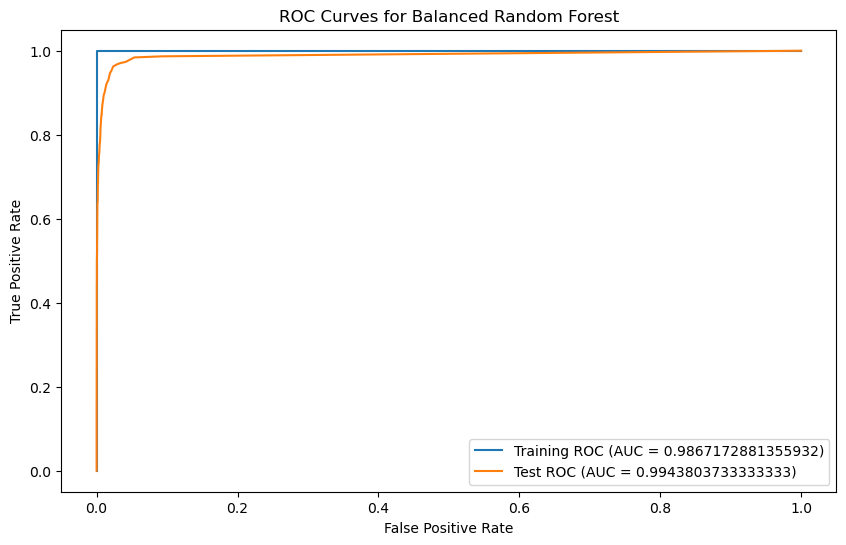

In [19]:
rf_balanced = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42, class_weight='balanced')
rf_balanced.fit(X_train, y_train)

train_pred_balanced = rf_balanced.predict(X_train)
test_pred_balanced = rf_balanced.predict(X_test)

conf_train_balanced = confusion_matrix(y_train, train_pred_balanced)
conf_test_balanced = confusion_matrix(y_test, test_pred_balanced)

prob_train_balanced = rf_balanced.predict_proba(X_train)[:, 1]
prob_test_balanced = rf_balanced.predict_proba(X_test)[:, 1]

fpr_train_balanced, tpr_train_balanced, thresholds = roc_curve(y_train, prob_train_balanced)
fpr_test_balanced, tpr_test_balanced, thresholds = roc_curve(y_test, prob_test_balanced)

auc_train_balanced = roc_auc_score(y_train, prob_train_balanced)
auc_test_balanced = roc_auc_score(y_test, prob_test_balanced)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train_balanced, tpr_train_balanced, label=f'Training ROC (AUC = {auc_train})')
plt.plot(fpr_test_balanced, tpr_test_balanced, label=f'Test ROC (AUC = {auc_test})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Balanced Random Forest")
plt.legend(loc="best")
plt.show()

In [20]:
print(f'Balanced Training Confusion Matrix: {conf_train_balanced}')
print(f'Balanced Testing Confusion Matrix: {conf_test_balanced}')

print(f'Balanced Training AUC: {auc_train_balanced}')
print(f'Balanced Test AUC: {auc_test_balanced}')

misclass_train_balanced = 1 - accuracy_score(y_train, train_pred_balanced)
misclass_test_balanced = 1 - accuracy_score(y_test, test_pred_balanced)
print(f'Balanced Training Misclassification: {misclass_train_balanced}')
print(f'Balanced Test Misclassification: {misclass_test_balanced}')

oob_error_balanced = 1 - rf_balanced.oob_score_
print(f'Balanced Out-of-Bag Error Estimate: {oob_error_balanced}')
print(f'Balanced Test Error: {misclass_test_balanced}')

Balanced Training Confusion Matrix: [[59000     0]
 [    1   999]]
Balanced Testing Confusion Matrix: [[15613    12]
 [  167   208]]
Balanced Training AUC: 1.0
Balanced Test AUC: 0.989289984
Balanced Training Misclassification: 1.666666666666483e-05
Balanced Test Misclassification: 0.011187500000000017
Balanced Out-of-Bag Error Estimate: 0.007783333333333364
Balanced Test Error: 0.011187500000000017


Balancing the dataset reduce errors for the minority class, lowering the test misclassification rate and increases auc. However, this led to overfitting on the training data, seen in the perfect AUC.

### (e) XGBoost and Model Trees

In [21]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

param_grid = {
    'alpha': [0, 0.01, 0.1, 1, 10],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print('Best parameters found: {best_params}')

final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    alpha=best_params['alpha'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train, y_train)


final_y_train_pred = final_model.predict(X_train)
final_y_test_pred = final_model.predict(X_test)

final_y_train_proba = final_model.predict_proba(X_train)[:, 1]
final_y_test_proba = final_model.predict_proba(X_test)[:, 1]

final_conf_train = confusion_matrix(y_train, final_y_train_pred)
final_conf_test = confusion_matrix(y_test, final_y_test_pred)

final_train_auc = roc_auc_score(y_train, final_y_train_proba)
final_test_auc = roc_auc_score(y_test, final_y_test_proba)

final_fpr_train, final_tpr_train, thresholds = roc_curve(y_train, final_y_train_proba)
final_fpr_test, final_tpr_test, thresholds = roc_curve(y_test, final_y_test_proba)

misclass_train = 1 - accuracy_score(y_train, final_y_train_pred)
misclass_test = 1 - accuracy_score(y_test, final_y_test_pred)

cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='roc_auc')
cv_error = 1 - np.mean(cv_scores)

print("Training Confusion Matrix:\n", final_conf_train)
print("Testing Confusion Matrix:\n", final_conf_test)
print(f"Training AUC: {final_train_auc}")
print(f"Test AUC: {final_test_auc}")
print(f"Training Misclassification: {misclass_train}")
print(f"Test Misclassification: {misclass_test}")
print(f"Cross-Validation Error (5-fold): {cv_error}")
print(f"Test Error: {misclass_test}")


/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/py

Best parameters found: {best_params}


/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:24:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:24:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:24:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/py

Training Confusion Matrix:
 [[58996     4]
 [   79   921]]
Testing Confusion Matrix:
 [[15610    15]
 [   88   287]]
Training AUC: 0.9995101694915254
Test AUC: 0.995830272
Training Misclassification: 0.001383333333333292
Test Misclassification: 0.006437499999999985
Cross-Validation Error (5-fold): 0.008288347457627077
Test Error: 0.006437499999999985


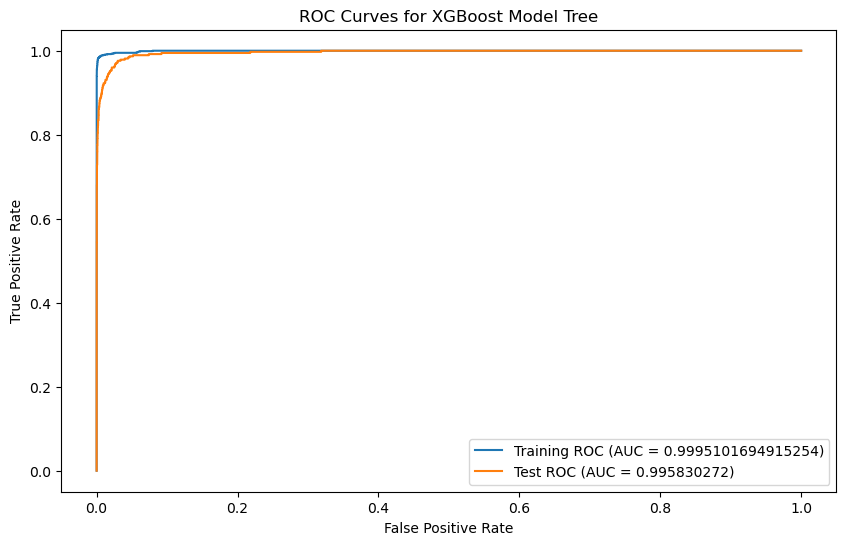

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(final_fpr_train, final_tpr_train, label=f'Training ROC (AUC = {final_train_auc})')
plt.plot(final_fpr_test, final_tpr_test, label=f'Test ROC (AUC = {final_test_auc})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for XGBoost Model Tree")
plt.legend(loc="best")
plt.show()

### (f) Use SMOTE to pre-process your data

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

param_grid = {
    'alpha': [0, 0.01, 0.1, 1, 10],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

final_model_smote = xgb.XGBClassifier(
    objective='binary:logistic',
    alpha=best_params['alpha'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
final_model_smote.fit(X_train_resampled, y_train_resampled)

y_train_pred_smote = final_model_smote.predict(X_train_scaled)
y_test_pred_smote = final_model_smote.predict(X_test_scaled)
y_train_proba_smote = final_model_smote.predict_proba(X_train_scaled)[:, 1]
y_test_proba_smote = final_model_smote.predict_proba(X_test_scaled)[:, 1]

conf_train_smote = confusion_matrix(y_train, y_train_pred_smote)
conf_test_smote = confusion_matrix(y_test, y_test_pred_smote)

train_auc_smote = roc_auc_score(y_train, y_train_proba_smote)
test_auc_smote = roc_auc_score(y_test, y_test_proba_smote)

fpr_train_smote, tpr_train_smote, _ = roc_curve(y_train, y_train_proba_smote)
fpr_test_smote, tpr_test_smote, _ = roc_curve(y_test, y_test_proba_smote)

misclass_train_smote = 1 - accuracy_score(y_train, y_train_pred_smote)
misclass_test_smote = 1 - accuracy_score(y_test, y_test_pred_smote)

cv_scores_smote = cross_val_score(final_model_smote, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
cv_error_smote = 1 - np.mean(cv_scores_smote)



/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:25:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:25:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:25:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/py

Best parameters found: {'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:41:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:41:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:41:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/herunkan/Coding/ENVS/miniconda3/envs/minimal_ds/lib/py

In [24]:
print("Training Confusion Matrix (SMOTE):\n", conf_train_smote)
print("Testing Confusion Matrix (SMOTE):\n", conf_test_smote)
print(f"Training AUC (SMOTE): {train_auc_smote}")
print(f"Test AUC (SMOTE): {test_auc_smote}")
print(f"Training Misclassification (SMOTE): {misclass_train_smote}")
print(f"Test Misclassification (SMOTE): {misclass_test_smote}")
print(f"Cross-Validation Error (5-fold, SMOTE): {cv_error_smote}")
print(f"Test Error (SMOTE): {misclass_test_smote}")

Training Confusion Matrix (SMOTE):
 [[59000     0]
 [    1   999]]
Testing Confusion Matrix (SMOTE):
 [[15535    90]
 [   49   326]]
Training AUC (SMOTE): 0.9999972542372881
Test AUC (SMOTE): 0.994988032
Training Misclassification (SMOTE): 1.666666666666483e-05
Test Misclassification (SMOTE): 0.00868749999999996
Cross-Validation Error (5-fold, SMOTE): 6.0419419707025135e-05
Test Error (SMOTE): 0.00868749999999996


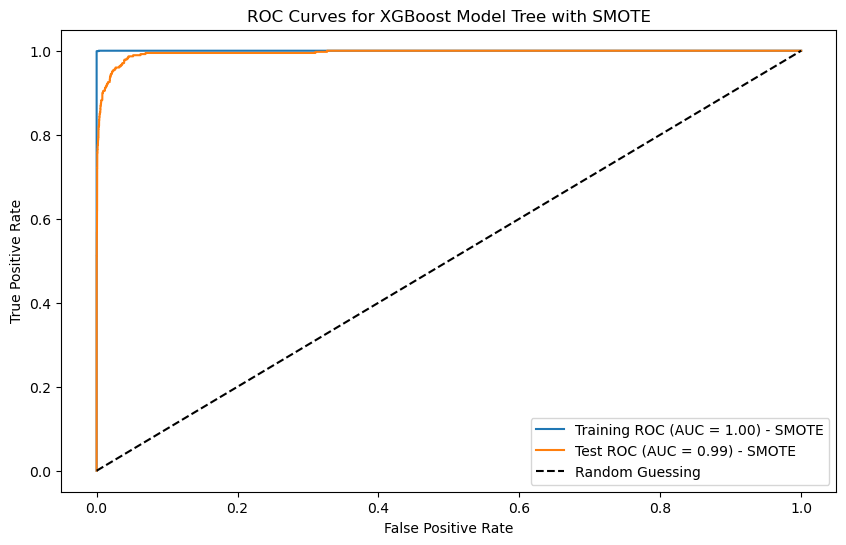

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_train_smote, tpr_train_smote, label=f'Training ROC (AUC = {train_auc_smote:.2f}) - SMOTE')
plt.plot(fpr_test_smote, tpr_test_smote, label=f'Test ROC (AUC = {test_auc_smote:.2f}) - SMOTE')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for XGBoost Model Tree with SMOTE")
plt.legend(loc="best")
plt.show()

## 2. ISLR 6.6.3

a.As we increase “s” in ridge regression, the training RSS decreases.

Initially, the model is restricted and poorly fits the training data (high RSS), but as “s” increases, it becomes more flexible and better fits the data, leading to a decreasing RSS.

b.As s increase, the training RSS initially decreases and then increases in a U shape.

At one point the variance increases faster than the bias decreases, causing overfitting and an increase in the test RSS.

c. As s increases, the variance steadily increases 


d. squared bias steadily decreases

e. does not change

## 3. ISLR 6.6.5

## 4. ISLR 8.4.5

Majority poll:
0.1, 0.15, 0.2, 0.2  less than 0.5  Green
0.55, 0.6, 0.6, 0.65, 0.7, 0.75  greater than 0.5 Red

Average:
0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75 
The average probability is 0.5



Majority vote approach: Red
Average probablity: could be either way


## 5. ISLR 9.7.3